### Stops extraction and classification

This section is in charge of extracting the stops for each travel and classifying them using K-means clustering. The main idea is to find consecutive GPS points whose duration is longer than a threshold, in this case, 3 minutes.

Following the proposed method in the case study “Identifying business activity-travel patterns based on GPS data” [3] it's necessary to build the locations given the following structure:
L(z, ts, te, day, dis, int)

| Variable | description |
| --- | --- |
| Z | Represents the GPS zone location |
| ts | Start time |
| te | End time |
| dis | distance from previous location |
| int | time to travel from previous location |

The duration of a stop is given by `(te - ts)`

The zone locations are build using K-mean clustering.


In [ ]:
! pip install pandas numpy matplotlib seaborn scikit-learn shapely geopandas

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import time as time
import seaborn as sns
from sklearn.cluster import KMeans
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [17]:
# Helper functions

def loadTravel(filename):
    travel = pd.read_csv(filename, sep=',', skiprows=0)
    return travel

speedThreshold = 0
durationThreshold = 2

#id,date,speed,longitude,latitude,description,direction,distance

 #if each point has Speedk = 0 (k = i...j) and the duration (tj–ti) is
#longer than a parameter THStop, the points are clustered into a stop where the perso

def buildLocation(travel, stops):
    i = 0
    stopId = 0

    print(len(travel))
    while i < len(travel) - 1:
        # print(travel[i]);
        first = travel[i]
        second = travel[i+1]

        print(first)
        print(second)
        
        if first[2] == speedThreshold and second[2] == speedThreshold:
            ts = first[1]
            te = second[1]

            duration = te-ts

            if duration > durationThreshold:
                sp = [stopId, ts, first[3],  first[4], first[7]]
                stops.append(sp)

                print(stopId)
        elif first[2] == speedThreshold:
            stops.append([stopId, te, first[3],  first[4], first[7]])
            stopId += 1
        elif second[2] == speedThreshold:
            stopId += 1
            stops.append([stopId, te, second[3],  second[4], second[7]])
            
        i = i + 1

def extractStop(travel, locations, stops):
    t = travel[['id','latitude', 'longitude']]
    # t = t.drop_duplicates(subset=('longitude', 'latitude'), keep="first")
    # print(t)
    locations.extend(t.values.tolist())
    buildLocation(travel.values.tolist(), stops)
    print('Locations size: ',len(locations))


In [38]:
# cluster stops

def clusterStops(stops):
    
    cluster = pd.DataFrame(stops, columns=['id', 'ts', 'lat', 'lon', 'dis'])

    group = cluster.groupby('id')
    first = group.first()
    last = group.last()

    r = group.agg({"lat": "mean", "lon": "mean", "dis": "sum"})
    r['ts'] = first['ts']
    r['te'] = last['ts']
    r['id'] = first['id']

    return r


In [42]:
#plot locations
def plotStops(stops):
    print('Plot cluster')
        #Plot each gps point
    geo = GeoDataFrame(stops, geometry = gpd.points_from_xy(stops.lon, stops.lat))
    w = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    w = w[w.name == "Colombia"].plot(color= 'lightblue', edgecolor='black')
    plt.title('GPS points for each event in Colombia')

    geo.plot(ax=w, color = 'darkblue', markersize=0.4);
    

In [45]:

# assign directory
directory = '../datasets/travels'
 
# iterate over files in
# that directory
coordinates = []

stopsByTravel = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file

    if os.path.isfile(f):

        try:
            travel = loadTravel(f)
            stops = []
            extractStop(travel, coordinates, stops)

            # id = filename.find('-')
            stopFilename = filename.replace('travel', 'stops') 
 
            cluster = clusterStops(stops)
            cluster.to_csv('../datasets/stops/%s.csv'%(stopFilename), header=True,  index=False)

            # print(filename[0:id])
            # stopsByTravel.append([filename[0:id],len(cluster)])

            # plotStops(cluster)

            

            print(cluster)

        except Exception:
            print("Some other exception", f)


82
[96483, 1664598266000, 0, -75.20303, 7.972711, 'Ignición -> Prendida', 270, 0.0]
[97989, 1664598287000, 0, -75.20303, 7.972711, 'Ignición -> Apagada', 270, 0.0]
0
[97989, 1664598287000, 0, -75.20303, 7.972711, 'Ignición -> Apagada', 270, 0.0]
[160258, 1664599211000, 0, -75.20303, 7.972711, 'Ignición -> Prendida', 270, 0.0]
0
[160258, 1664599211000, 0, -75.20303, 7.972711, 'Ignición -> Prendida', 270, 0.0]
[160604, 1664599217000, 0, -75.20303, 7.972711, 'Ignición -> Apagada', 270, 0.0]
0
[160604, 1664599217000, 0, -75.20303, 7.972711, 'Ignición -> Apagada', 270, 0.0]
[303795, 1664601417000, 0, -75.203027, 7.972672, 'Ignición -> Prendida', 270, 0.0043491672923692]
0
[303795, 1664601417000, 0, -75.203027, 7.972672, 'Ignición -> Prendida', 270, 0.0043491672923692]
[304996, 1664601435000, 2, -75.203027, 7.972672, 'Ignición -> Apagada', 270, 0.0]
[304996, 1664601435000, 2, -75.203027, 7.972672, 'Ignición -> Apagada', 270, 0.0]
[860016, 1664610414000, 0, -75.202976, 7.972627, 'Ignición -> 

In [46]:
gpsZones = pd.DataFrame(coordinates, columns=['id', 'latitude', 'longitude'])
gpsZones.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
print('Gps zones size:', len(gpsZones))

gpsZones.head(10)

Gps zones size: 82


,id,latitude,longitude
0,96483.0,7.972711,-75.203030
1,97989.0,7.972711,-75.203030
2,160258.0,7.972711,-75.203030
3,160604.0,7.972711,-75.203030
4,303795.0,7.972672,-75.203027
5,304996.0,7.972672,-75.203027
6,860016.0,7.972627,-75.202976
7,916705.0,7.935158,-75.209770
8,935550.0,7.865913,-75.217815
9,978818.0,7.800804,-75.203948


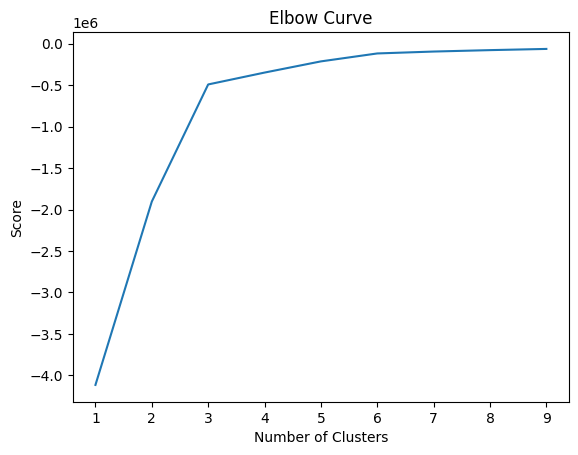

In [7]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = gpsZones[['latitude']]
X_axis = gpsZones[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [8]:
kmeans = KMeans(n_clusters = 5, init ='k-means++')
kmeans.fit(gpsZones[gpsZones.columns[1:3]]) # Compute k-means clustering.
gpsZones['cluster'] = kmeans.fit_predict(gpsZones[gpsZones.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(gpsZones[gpsZones.columns[1:3]]) # Labels of each point
gpsZones.head(10)


,id,latitude,longitude,cluster
0,5580.0,4.622721,-74.090770,1
1,30839.0,4.622721,-74.090770,1
2,52356.0,4.622721,-74.090770,1
3,72708.0,4.622721,-74.090770,1
4,90602.0,4.622718,-74.090765,1
5,112083.0,4.622718,-74.090765,1
6,132301.0,4.622718,-74.090765,1
7,144882.0,4.622718,-74.090765,1
8,172511.0,4.622728,-74.090721,1
9,193286.0,4.622728,-74.090721,1


In [ ]:
gpsZones.to_csv('../datasets/gps-zone-clusters.csv', index=False)

Text(0.5, 1.0, 'GPS Points By Cluster in Colombia')

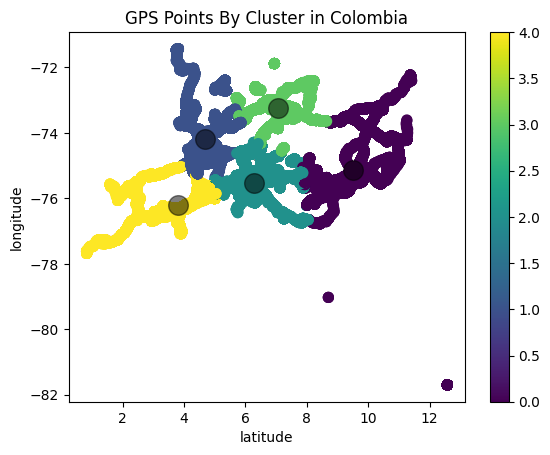

In [15]:


gpsZones.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

plt.title('GPS Points By Cluster in Colombia')



In [135]:
print(gpsZones.head(5))

geo = GeoDataFrame(gpsZones, geometry = gpd.points_from_xy(gpsZones.longitude, gpsZones.latitude))

        id  latitude  longitude  cluster                   geometry
0   5580.0  4.622721 -74.090770        4  POINT (-74.09077 4.62272)
1  30839.0  4.622721 -74.090770        4  POINT (-74.09077 4.62272)
2  52356.0  4.622721 -74.090770        4  POINT (-74.09077 4.62272)
3  72708.0  4.622721 -74.090770        4  POINT (-74.09077 4.62272)
4  90602.0  4.622718 -74.090765        4  POINT (-74.09077 4.62272)


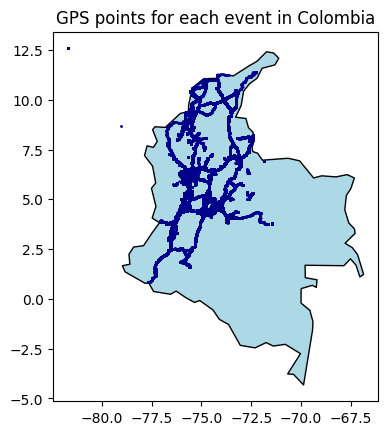

In [141]:
#Plot each gps point
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name == "Colombia"].plot(color= 'lightblue', edgecolor='black')
plt.title('GPS points for each event in Colombia')

geo.plot(ax=world, color = 'darkblue', markersize=0.4);

